### Load in the SAEs from Huggingface Hub.

In [ ]:
def install_dependencies():
    ! rm -rf sae || True
    ! git clone https://github.com/amirabdullah19852020/sae.git
    ! cd sae && pip install .
    ! git clone https://github.com/withmartian/TinySQL.git
    ! cd TinySQL && pip install .

install_dependencies()

In [1]:
import json
import os

os.environ["SAE_DISABLE_TRITON"] = "1"

import psutil
import re

from copy import deepcopy
from dataclasses import dataclass
from IPython.display import display, HTML
from typing import Callable
from math import ceil
from pathlib import Path

import nnsight
import numpy as np
import plotly.graph_objects as go
import sae
import torch
import torch.fx

from datasets import load_dataset
from huggingface_hub import snapshot_download
import matplotlib.pyplot as plt
from nnsight import NNsight, LanguageModel
from plotly.subplots import make_subplots
from sae import Sae
from sae.sae_interp import GroupedSaeOutput, SaeOutput, SaeCollector, LoadedSAES
from sae.sae_plotting import plot_layer_curves, plot_layer_features

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from TinySQL import sql_interp_model_location
from TinySQL.training_data.fragments import field_names, table_names

Triton disabled, using eager implementation of SAE decoder.


In [2]:
# Get the current process
def process_info():
    process = psutil.Process(os.getpid())
    
    # Memory usage in MB
    memory_info = process.memory_info()
    print(f"RSS: {memory_info.rss / (1024 ** 2):.2f} MB")  # Resident Set Size
    print(f"VMS: {memory_info.vms / (1024 ** 2):.2f} MB") 

process_info()

RSS: 669.55 MB
VMS: 5282.45 MB


In [3]:
seed=42
repo = "sql_interp_saes"

In [4]:
repo_name = "withmartian/sql_interp_saes"
cache_dir = "working_directory"

syn=True

full_model_name = sql_interp_model_location(model_num=1, cs_num=1, synonym=syn)
model_alias = f"saes_{full_model_name.split('/')[1]}_syn={syn}"
print(model_alias)

# Change this to work with another model alias.
seed = 42

process_info()

saes_sql_interp_bm1_cs1_experiment_1.10_syn=True
RSS: 669.81 MB
VMS: 5282.45 MB


In [5]:
repo_path = Path(
    snapshot_download(repo_name, allow_patterns=f"{model_alias}/*", local_dir=cache_dir)
)

In [6]:
cache_dir

'working_directory'

In [7]:
def format_example(example):
    alpaca_prompt = "### Instruction: {} ### Context: {} ### Response: {}"
    example['prompt'] = alpaca_prompt.format(example['english_prompt'], example['create_statement'], example['sql_statement'])
    example['response'] = example['sql_statement']
    return example

In [9]:
loaded_saes = LoadedSAES.load_from_path(model_alias=model_alias, k=128, cache_dir=cache_dir, dataset_mapper=format_example)

Loading from path working_directory/saes_sql_interp_bm1_cs1_experiment_1.10_syn=True/k=128


In [13]:
sae_collector = SaeCollector(loaded_saes, seed=seed, sample_size=200)
sae_collector.get_texts()

  0%|▍                                                                                             | 1/200 [00:00<02:03,  1.61it/s]

Found response token search


  1%|▉                                                                                             | 2/200 [00:00<01:29,  2.22it/s]

Found response token media


  2%|█▍                                                                                            | 3/200 [00:01<01:20,  2.45it/s]

Found response token customer


  2%|█▉                                                                                            | 4/200 [00:01<01:10,  2.77it/s]

Found response token document


  2%|██▎                                                                                           | 5/200 [00:01<01:07,  2.87it/s]

Found response token report


  3%|██▊                                                                                           | 6/200 [00:02<01:03,  3.07it/s]

Found response token customers


  4%|███▎                                                                                          | 7/200 [00:02<01:01,  3.12it/s]

Found response token workflow


  4%|███▊                                                                                          | 8/200 [00:02<00:59,  3.22it/s]

Found response token jobs


  4%|████▏                                                                                         | 9/200 [00:03<01:04,  2.96it/s]

Found response token brand


  5%|████▋                                                                                        | 10/200 [00:03<01:08,  2.76it/s]

Found response token contact


  6%|█████                                                                                        | 11/200 [00:03<01:05,  2.89it/s]

Found response token api


  6%|█████▌                                                                                       | 12/200 [00:04<01:12,  2.59it/s]

Found response token search


  6%|██████                                                                                       | 13/200 [00:04<01:16,  2.45it/s]

Found response token password


  7%|██████▌                                                                                      | 14/200 [00:05<01:12,  2.56it/s]

Found response token subscription


  8%|██████▉                                                                                      | 15/200 [00:05<01:16,  2.42it/s]

Found response token report


  8%|███████▍                                                                                     | 16/200 [00:06<01:13,  2.49it/s]

Found response token archive


  8%|███████▉                                                                                     | 17/200 [00:06<01:08,  2.66it/s]

Found response token dates


  9%|████████▎                                                                                    | 18/200 [00:06<01:04,  2.83it/s]

Found response token wish


 10%|████████▊                                                                                    | 19/200 [00:06<01:00,  2.99it/s]

Found response token milestones


 10%|█████████▎                                                                                   | 20/200 [00:07<00:58,  3.06it/s]

Found response token wish


 10%|█████████▊                                                                                   | 21/200 [00:07<01:00,  2.95it/s]

Found response token support


 11%|██████████▏                                                                                  | 22/200 [00:07<00:57,  3.10it/s]

Found response token document


 12%|██████████▋                                                                                  | 23/200 [00:08<01:05,  2.72it/s]

Found response token wish


 12%|███████████▏                                                                                 | 24/200 [00:08<01:11,  2.45it/s]

Found response token profile


 12%|███████████▋                                                                                 | 25/200 [00:09<01:15,  2.32it/s]

Found response token document


 13%|████████████                                                                                 | 26/200 [00:09<01:09,  2.50it/s]

Found response token document


 14%|████████████▌                                                                                | 27/200 [00:10<01:35,  1.81it/s]

Found response token search


 14%|█████████████                                                                                | 28/200 [00:10<01:21,  2.12it/s]

Found response token settings


 14%|█████████████▍                                                                               | 29/200 [00:11<01:20,  2.13it/s]

Found response token performance


 15%|█████████████▉                                                                               | 30/200 [00:11<01:13,  2.32it/s]

Found response token locations


 16%|██████████████▍                                                                              | 31/200 [00:12<01:06,  2.53it/s]

Found response token event


 16%|██████████████▉                                                                              | 32/200 [00:12<01:10,  2.37it/s]

Found response token project


 16%|███████████████▎                                                                             | 33/200 [00:12<01:08,  2.42it/s]

Found response token favorites


 17%|███████████████▊                                                                             | 34/200 [00:13<01:04,  2.58it/s]

Found response token document


 18%|████████████████▎                                                                            | 35/200 [00:13<01:03,  2.61it/s]

Found response token user


 18%|████████████████▋                                                                            | 36/200 [00:13<01:03,  2.59it/s]

Found response token product


 18%|█████████████████▏                                                                           | 37/200 [00:14<00:58,  2.80it/s]

Found response token attachments


 19%|█████████████████▋                                                                           | 38/200 [00:14<00:58,  2.76it/s]

Found response token audio


 20%|██████████████████▏                                                                          | 39/200 [00:14<00:57,  2.81it/s]

Found response token lists


 20%|██████████████████▌                                                                          | 40/200 [00:15<00:56,  2.81it/s]

Found response token refunds


 20%|███████████████████                                                                          | 41/200 [00:15<00:59,  2.69it/s]

Found response token api


 21%|███████████████████▌                                                                         | 42/200 [00:16<00:58,  2.69it/s]

Found response token groups


 22%|███████████████████▉                                                                         | 43/200 [00:16<00:56,  2.80it/s]

Found response token jobs


 22%|████████████████████▍                                                                        | 44/200 [00:16<00:55,  2.83it/s]

Found response token content


 22%|████████████████████▉                                                                        | 45/200 [00:17<00:56,  2.75it/s]

Found response token search


 23%|█████████████████████▍                                                                       | 46/200 [00:17<00:55,  2.78it/s]

Found response token courses


 24%|█████████████████████▊                                                                       | 47/200 [00:17<00:54,  2.80it/s]

Found response token risk


 24%|██████████████████████▎                                                                      | 48/200 [00:18<00:50,  3.03it/s]

Found response token customers


 24%|██████████████████████▊                                                                      | 49/200 [00:18<00:48,  3.10it/s]

Found response token product


 25%|███████████████████████▎                                                                     | 50/200 [00:18<00:48,  3.08it/s]

Found response token profile


 26%|███████████████████████▋                                                                     | 51/200 [00:19<00:48,  3.10it/s]

Found response token security


 26%|████████████████████████▏                                                                    | 52/200 [00:19<00:45,  3.23it/s]

Found response token document


 26%|████████████████████████▋                                                                    | 53/200 [00:19<00:54,  2.69it/s]

Found response token quality


 27%|█████████████████████████                                                                    | 54/200 [00:20<00:51,  2.83it/s]

Found response token workflow


 28%|█████████████████████████▌                                                                   | 55/200 [00:20<00:50,  2.88it/s]

Found response token workflow


 28%|██████████████████████████                                                                   | 56/200 [00:20<00:47,  3.04it/s]

Found response token maps


 28%|██████████████████████████▌                                                                  | 57/200 [00:21<00:44,  3.20it/s]

Found response token order


 29%|██████████████████████████▉                                                                  | 58/200 [00:21<00:46,  3.03it/s]

Found response token api


 30%|███████████████████████████▍                                                                 | 59/200 [00:21<00:48,  2.90it/s]

Found response token login


 30%|███████████████████████████▉                                                                 | 60/200 [00:22<00:53,  2.63it/s]

Found response token audit


 30%|████████████████████████████▎                                                                | 61/200 [00:22<00:48,  2.85it/s]

Found response token security


 31%|████████████████████████████▊                                                                | 62/200 [00:22<00:46,  2.99it/s]

Found response token profile


 32%|█████████████████████████████▎                                                               | 63/200 [00:23<00:53,  2.57it/s]

Found response token schedule


 32%|█████████████████████████████▊                                                               | 64/200 [00:23<00:49,  2.73it/s]

Found response token recurring


 32%|██████████████████████████████▏                                                              | 65/200 [00:24<00:47,  2.85it/s]

Found response token quality


 33%|██████████████████████████████▋                                                              | 66/200 [00:24<00:44,  3.01it/s]

Found response token api


 34%|███████████████████████████████▏                                                             | 67/200 [00:24<00:51,  2.59it/s]

Found response token social


 34%|███████████████████████████████▌                                                             | 68/200 [00:25<00:51,  2.58it/s]

Found response token workflow


 34%|████████████████████████████████                                                             | 69/200 [00:25<00:51,  2.54it/s]

Found response token videos


 35%|████████████████████████████████▌                                                            | 70/200 [00:25<00:48,  2.68it/s]

Found response token service


 36%|█████████████████████████████████                                                            | 71/200 [00:26<00:51,  2.51it/s]

Found response token workflow


 36%|█████████████████████████████████▍                                                           | 72/200 [00:26<00:48,  2.66it/s]

Found response token appointments


 36%|█████████████████████████████████▉                                                           | 73/200 [00:27<00:47,  2.68it/s]

Found response token messages


 37%|██████████████████████████████████▍                                                          | 74/200 [00:27<00:50,  2.48it/s]

Found response token push


 38%|██████████████████████████████████▉                                                          | 75/200 [00:27<00:49,  2.50it/s]

Found response token report


 38%|███████████████████████████████████▎                                                         | 76/200 [00:28<00:50,  2.47it/s]

Found response token campaigns


 38%|███████████████████████████████████▊                                                         | 77/200 [00:28<00:48,  2.56it/s]

Found response token pairs


 39%|████████████████████████████████████▎                                                        | 78/200 [00:29<00:55,  2.21it/s]

Found response token appointments


 40%|████████████████████████████████████▋                                                        | 79/200 [00:29<00:59,  2.03it/s]

Found response token support


 40%|█████████████████████████████████████▏                                                       | 80/200 [00:30<00:53,  2.23it/s]

Found response token month


 40%|█████████████████████████████████████▋                                                       | 81/200 [00:30<00:51,  2.33it/s]

Found response token feature


 41%|██████████████████████████████████████▏                                                      | 82/200 [00:31<00:48,  2.43it/s]

Found response token quality


 42%|██████████████████████████████████████▌                                                      | 83/200 [00:31<00:46,  2.51it/s]

Found response token shipping


 42%|███████████████████████████████████████                                                      | 84/200 [00:31<00:44,  2.62it/s]

Found response token calendars


 42%|███████████████████████████████████████▌                                                     | 85/200 [00:32<00:41,  2.76it/s]

Found response token schedule


 43%|███████████████████████████████████████▉                                                     | 86/200 [00:32<00:39,  2.92it/s]

Found response token social


 44%|████████████████████████████████████████▍                                                    | 87/200 [00:32<00:37,  3.03it/s]

Found response token settings


 44%|████████████████████████████████████████▉                                                    | 88/200 [00:32<00:35,  3.14it/s]

Found response token numbers


 44%|█████████████████████████████████████████▍                                                   | 89/200 [00:33<00:39,  2.80it/s]

Found response token notifications


 45%|█████████████████████████████████████████▊                                                   | 90/200 [00:33<00:36,  2.99it/s]

Found response token hold


 46%|██████████████████████████████████████████▎                                                  | 91/200 [00:34<00:39,  2.77it/s]

Found response token access


 46%|██████████████████████████████████████████▊                                                  | 92/200 [00:35<01:06,  1.61it/s]

Found response token report


 46%|███████████████████████████████████████████▏                                                 | 93/200 [00:35<00:57,  1.85it/s]

Found response token subscription


 47%|███████████████████████████████████████████▋                                                 | 94/200 [00:36<00:51,  2.07it/s]

Found response token content


 48%|████████████████████████████████████████████▏                                                | 95/200 [00:36<00:50,  2.07it/s]

Found response token comments


 48%|████████████████████████████████████████████▋                                                | 96/200 [00:36<00:47,  2.21it/s]

Found response token content


 48%|█████████████████████████████████████████████                                                | 97/200 [00:37<00:42,  2.42it/s]

Found response token articles


 49%|█████████████████████████████████████████████▌                                               | 98/200 [00:37<00:44,  2.30it/s]

Found response token comments


 50%|██████████████████████████████████████████████                                               | 99/200 [00:38<00:42,  2.36it/s]

Found response token content


 50%|██████████████████████████████████████████████                                              | 100/200 [00:38<00:39,  2.54it/s]

Found response token corrective


 50%|██████████████████████████████████████████████▍                                             | 101/200 [00:38<00:37,  2.61it/s]

Found response token addresses


 51%|██████████████████████████████████████████████▉                                             | 102/200 [00:39<00:36,  2.69it/s]

Found response token content


 52%|███████████████████████████████████████████████▍                                            | 103/200 [00:39<00:38,  2.53it/s]

Found response token workflow


 52%|███████████████████████████████████████████████▊                                            | 104/200 [00:40<00:42,  2.26it/s]

Found response token quality


 52%|████████████████████████████████████████████████▎                                           | 105/200 [00:40<00:47,  2.01it/s]

Found response token billing


 53%|████████████████████████████████████████████████▊                                           | 106/200 [00:41<00:48,  1.94it/s]

Found response token social


 54%|█████████████████████████████████████████████████▏                                          | 107/200 [00:41<00:49,  1.87it/s]

Found response token documents


 54%|█████████████████████████████████████████████████▋                                          | 108/200 [00:42<00:43,  2.13it/s]

Found response token content


 55%|██████████████████████████████████████████████████▏                                         | 109/200 [00:42<00:39,  2.28it/s]

Found response token events


 55%|██████████████████████████████████████████████████▌                                         | 110/200 [00:42<00:35,  2.54it/s]

Found response token product


 56%|███████████████████████████████████████████████████                                         | 111/200 [00:43<00:36,  2.41it/s]

Found response token names


 56%|███████████████████████████████████████████████████▌                                        | 112/200 [00:43<00:34,  2.54it/s]

Found response token performance


 56%|███████████████████████████████████████████████████▉                                        | 113/200 [00:44<00:32,  2.68it/s]

Found response token event


 57%|████████████████████████████████████████████████████▍                                       | 114/200 [00:44<00:30,  2.80it/s]

Found response token conversion


 57%|████████████████████████████████████████████████████▉                                       | 115/200 [00:44<00:28,  3.00it/s]

Found response token year


 58%|█████████████████████████████████████████████████████▎                                      | 116/200 [00:44<00:26,  3.12it/s]

Found response token lists


 58%|█████████████████████████████████████████████████████▊                                      | 117/200 [00:45<00:27,  3.03it/s]

Found response token content


 59%|██████████████████████████████████████████████████████▎                                     | 118/200 [00:45<00:28,  2.90it/s]

Found response token place


 60%|██████████████████████████████████████████████████████▋                                     | 119/200 [00:46<00:30,  2.65it/s]

Found response token marketing


 60%|███████████████████████████████████████████████████████▏                                    | 120/200 [00:46<00:29,  2.76it/s]

Found response token workflow


 60%|███████████████████████████████████████████████████████▋                                    | 121/200 [00:46<00:31,  2.55it/s]

Found response token content


 61%|████████████████████████████████████████████████████████                                    | 122/200 [00:47<00:27,  2.79it/s]

Found response token categories


 62%|████████████████████████████████████████████████████████▌                                   | 123/200 [00:47<00:26,  2.88it/s]

Found response token postal


 62%|█████████████████████████████████████████████████████████                                   | 124/200 [00:47<00:27,  2.81it/s]

Found response token search


 62%|█████████████████████████████████████████████████████████▌                                  | 125/200 [00:48<00:24,  3.00it/s]

Found response token content


 63%|█████████████████████████████████████████████████████████▉                                  | 126/200 [00:48<00:23,  3.12it/s]

Found response token customer


 64%|██████████████████████████████████████████████████████████▍                                 | 127/200 [00:48<00:23,  3.05it/s]

Found response token day


 64%|██████████████████████████████████████████████████████████▉                                 | 128/200 [00:49<00:26,  2.67it/s]

Found response token content


 64%|███████████████████████████████████████████████████████████▎                                | 129/200 [00:49<00:33,  2.09it/s]

Found response token log


 65%|███████████████████████████████████████████████████████████▊                                | 130/200 [00:50<00:33,  2.06it/s]

Found response token payment


 66%|████████████████████████████████████████████████████████████▎                               | 131/200 [00:50<00:32,  2.12it/s]

Found response token document


 66%|████████████████████████████████████████████████████████████▋                               | 132/200 [00:51<00:28,  2.39it/s]

Found response token metrics


 66%|█████████████████████████████████████████████████████████████▏                              | 133/200 [00:51<00:26,  2.57it/s]

Found response token user


 67%|█████████████████████████████████████████████████████████████▋                              | 134/200 [00:51<00:25,  2.63it/s]

Found response token user


 68%|██████████████████████████████████████████████████████████████                              | 135/200 [00:52<00:24,  2.61it/s]

Found response token feature


 68%|██████████████████████████████████████████████████████████████▌                             | 136/200 [00:52<00:22,  2.81it/s]

Found response token document


 68%|███████████████████████████████████████████████████████████████                             | 137/200 [00:52<00:21,  2.97it/s]

Found response token document


 69%|███████████████████████████████████████████████████████████████▍                            | 138/200 [00:53<00:23,  2.61it/s]

Found response token email


 70%|███████████████████████████████████████████████████████████████▉                            | 139/200 [00:53<00:21,  2.83it/s]

Found response token content


 70%|████████████████████████████████████████████████████████████████▍                           | 140/200 [00:53<00:20,  2.90it/s]

Found response token content


 70%|████████████████████████████████████████████████████████████████▊                           | 141/200 [00:54<00:20,  2.88it/s]

Found response token product


 71%|█████████████████████████████████████████████████████████████████▎                          | 142/200 [00:54<00:19,  2.95it/s]

Found response token audit


 72%|█████████████████████████████████████████████████████████████████▊                          | 143/200 [00:54<00:19,  2.90it/s]

Found response token social


 72%|██████████████████████████████████████████████████████████████████▏                         | 144/200 [00:55<00:18,  3.04it/s]

Found response token notifications


 72%|██████████████████████████████████████████████████████████████████▋                         | 145/200 [00:55<00:17,  3.09it/s]

Found response token product


 73%|███████████████████████████████████████████████████████████████████▏                        | 146/200 [00:55<00:17,  3.01it/s]

Found response token values


 74%|███████████████████████████████████████████████████████████████████▌                        | 147/200 [00:56<00:17,  2.96it/s]

Found response token project


 74%|████████████████████████████████████████████████████████████████████                        | 148/200 [00:56<00:17,  3.04it/s]

Found response token login


 74%|████████████████████████████████████████████████████████████████████▌                       | 149/200 [00:57<00:20,  2.53it/s]

Found response token data


 75%|█████████████████████████████████████████████████████████████████████                       | 150/200 [00:57<00:18,  2.66it/s]

Found response token risk


 76%|█████████████████████████████████████████████████████████████████████▍                      | 151/200 [00:57<00:17,  2.83it/s]

Found response token access


 76%|█████████████████████████████████████████████████████████████████████▉                      | 152/200 [00:58<00:15,  3.01it/s]

Found response token ratings


 76%|██████████████████████████████████████████████████████████████████████▍                     | 153/200 [00:58<00:15,  3.08it/s]

Found response token project


 77%|██████████████████████████████████████████████████████████████████████▊                     | 154/200 [00:58<00:14,  3.15it/s]

Found response token service


 78%|███████████████████████████████████████████████████████████████████████▎                    | 155/200 [01:00<00:31,  1.43it/s]

Found response token shipping


 78%|███████████████████████████████████████████████████████████████████████▊                    | 156/200 [01:00<00:24,  1.76it/s]

Found response token document


 78%|████████████████████████████████████████████████████████████████████████▏                   | 157/200 [01:00<00:20,  2.07it/s]

Found response token security


 79%|████████████████████████████████████████████████████████████████████████▋                   | 158/200 [01:01<00:18,  2.32it/s]

Found response token changes


 80%|█████████████████████████████████████████████████████████████████████████▏                  | 159/200 [01:01<00:16,  2.46it/s]

Found response token order
Found response token order


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 160/200 [01:01<00:15,  2.51it/s]

Found response token search


 80%|██████████████████████████████████████████████████████████████████████████                  | 161/200 [01:02<00:15,  2.59it/s]

Found response token report


 81%|██████████████████████████████████████████████████████████████████████████▌                 | 162/200 [01:02<00:13,  2.77it/s]

Found response token conversations


 82%|██████████████████████████████████████████████████████████████████████████▉                 | 163/200 [01:02<00:12,  2.94it/s]

Found response token joins


 82%|███████████████████████████████████████████████████████████████████████████▍                | 164/200 [01:03<00:11,  3.15it/s]

Found response token email


 82%|███████████████████████████████████████████████████████████████████████████▉                | 165/200 [01:03<00:10,  3.26it/s]

Found response token campaign


 83%|████████████████████████████████████████████████████████████████████████████▎               | 166/200 [01:03<00:12,  2.81it/s]

Found response token risk


 84%|████████████████████████████████████████████████████████████████████████████▊               | 167/200 [01:04<00:11,  2.92it/s]

Found response token marketing


 84%|█████████████████████████████████████████████████████████████████████████████▎              | 168/200 [01:04<00:10,  3.07it/s]

Found response token audit


 84%|█████████████████████████████████████████████████████████████████████████████▋              | 169/200 [01:04<00:11,  2.61it/s]

Found response token sign


 85%|██████████████████████████████████████████████████████████████████████████████▏             | 170/200 [01:05<00:10,  2.79it/s]

Found response token service


 86%|██████████████████████████████████████████████████████████████████████████████▋             | 171/200 [01:05<00:10,  2.90it/s]

Found response token address


 86%|███████████████████████████████████████████████████████████████████████████████             | 172/200 [01:06<00:11,  2.49it/s]

Found response token customer


 86%|███████████████████████████████████████████████████████████████████████████████▌            | 173/200 [01:06<00:10,  2.67it/s]

Found response token course


 87%|████████████████████████████████████████████████████████████████████████████████            | 174/200 [01:06<00:09,  2.84it/s]

Found response token escalation


 88%|████████████████████████████████████████████████████████████████████████████████▌           | 175/200 [01:07<00:09,  2.76it/s]

Found response token project


 88%|████████████████████████████████████████████████████████████████████████████████▉           | 176/200 [01:07<00:08,  2.97it/s]

Found response token cancel


 88%|█████████████████████████████████████████████████████████████████████████████████▍          | 177/200 [01:07<00:08,  2.86it/s]

Found response token marketing


 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 178/200 [01:08<00:07,  2.82it/s]

Found response token user


 90%|██████████████████████████████████████████████████████████████████████████████████▎         | 179/200 [01:08<00:07,  2.80it/s]

Found response token risk


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 180/200 [01:08<00:06,  2.93it/s]

Found response token brand


 90%|███████████████████████████████████████████████████████████████████████████████████▎        | 181/200 [01:09<00:06,  3.01it/s]

Found response token prices


 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 182/200 [01:09<00:05,  3.02it/s]

Found response token api


 92%|████████████████████████████████████████████████████████████████████████████████████▏       | 183/200 [01:09<00:05,  2.98it/s]

Found response token page


 92%|████████████████████████████████████████████████████████████████████████████████████▋       | 184/200 [01:10<00:05,  2.84it/s]

Found response token product


 92%|█████████████████████████████████████████████████████████████████████████████████████       | 185/200 [01:10<00:06,  2.46it/s]

Found response token active


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 186/200 [01:11<00:05,  2.52it/s]

Found response token complaints


 94%|██████████████████████████████████████████████████████████████████████████████████████      | 187/200 [01:11<00:04,  2.76it/s]

Found response token product


 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 188/200 [01:11<00:04,  2.97it/s]

Found response token service


 94%|██████████████████████████████████████████████████████████████████████████████████████▉     | 189/200 [01:11<00:03,  3.02it/s]

Found response token inv


 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 190/200 [01:12<00:03,  2.94it/s]

Found response token api


 96%|███████████████████████████████████████████████████████████████████████████████████████▊    | 191/200 [01:12<00:03,  2.95it/s]

Found response token media


 96%|████████████████████████████████████████████████████████████████████████████████████████▎   | 192/200 [01:13<00:02,  2.81it/s]

Found response token order


 96%|████████████████████████████████████████████████████████████████████████████████████████▊   | 193/200 [01:13<00:02,  2.98it/s]

Found response token videos


 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 194/200 [01:13<00:01,  3.12it/s]

Found response token calendars


 98%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 195/200 [01:14<00:01,  2.85it/s]

Found response token order


 98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 196/200 [01:14<00:01,  2.84it/s]

Found response token regions


 98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 197/200 [01:14<00:01,  2.58it/s]

Found response token conversion


 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 198/200 [01:15<00:00,  2.60it/s]

Found response token marketing


100%|███████████████████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:15<00:00,  2.60it/s]

Found response token api


100%|████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.63it/s]

Found response token workflow


['### Instruction: Can you get me recent message, date of birth, reply id, meta_keywords, url, downloads and referral from refinement options? ### Context: CREATE TABLE search_filters ( downloads BIGINT, passed BOOLEAN, website VARCHAR(255), discount DECIMAL(10,2), birthday DATE, is_active BOOLEAN, sequence SMALLINT, last_message TEXT, meta_keywords VARCHAR(500), response_id INTEGER, reference TEXT ) ### Response: SELECT last_message, birthday, response_id, meta_keywords, website, downloads, reference FROM search_filters',
 '### Instruction: I need a list of is_admin from digital assets ### Context: CREATE TABLE media ( parent_task_id BIGINT, team_id BIGINT, total_price DECIMAL(10,2), average_score DECIMAL(5,2), is_admin TINYINT(1), discount FLOAT, project_id INTEGER ) ### Response: SELECT is_admin FROM media',
 '### Instruction: Get currency, username, release_date, license and unseen count from service feedback ### Context: CREATE TABLE customer_satisfaction ( username VARCHAR(50), r

### Maximally activating latents

In [15]:
def compute_and_sort_weights(acts, indices):
    """
    Compute the summed weights of each index and sort them in descending order.

    Parameters:
    acts (list of list of float): Nested list of scores.
    indices (list of list of int): Nested list of indices corresponding to scores.

    Returns:
    list of tuple: Sorted elements by summed weights in descending order.
    """
    # Dictionary to store summed weights for each index
    weights = {}
    numel = 0

    for act_row, idx_row in zip(acts, indices):
        numel+=1
        for score, idx in zip(act_row, idx_row):
            weights[idx] = weights.get(idx, 0) + score

    for element in weights:
        weights[element]/=(numel or 1)

    # Sort by summed weight in descending order
    sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)

    return sorted_weights

In [71]:
tag = "RESPONSE_TABLE"

def get_sorted_weights_by_layer(sae_collector, tag):
    results = sae_collector.get_all_sae_outputs_for_tag(tag)
    aggregated_sae_features = {}
    layers = sae_collector.layers
    for layer in layers:
        all_top_acts = []
        all_top_indices = []
        for element in tqdm(results):
            all_top_acts.extend(element[layer].top_acts)
            all_top_indices.extend(element[layer].top_indices)
    
        sorted_weights = compute_and_sort_weights(all_top_acts, all_top_indices)
        aggregated_sae_features[layer] = {"top_acts": all_top_acts, "top_indices": all_top_indices, "sorted_weights": sorted_weights}
    return aggregated_sae_features


sorted_weights = get_sorted_weights_by_layer(sae_collector, tag)

100%|████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 415895.29it/s]


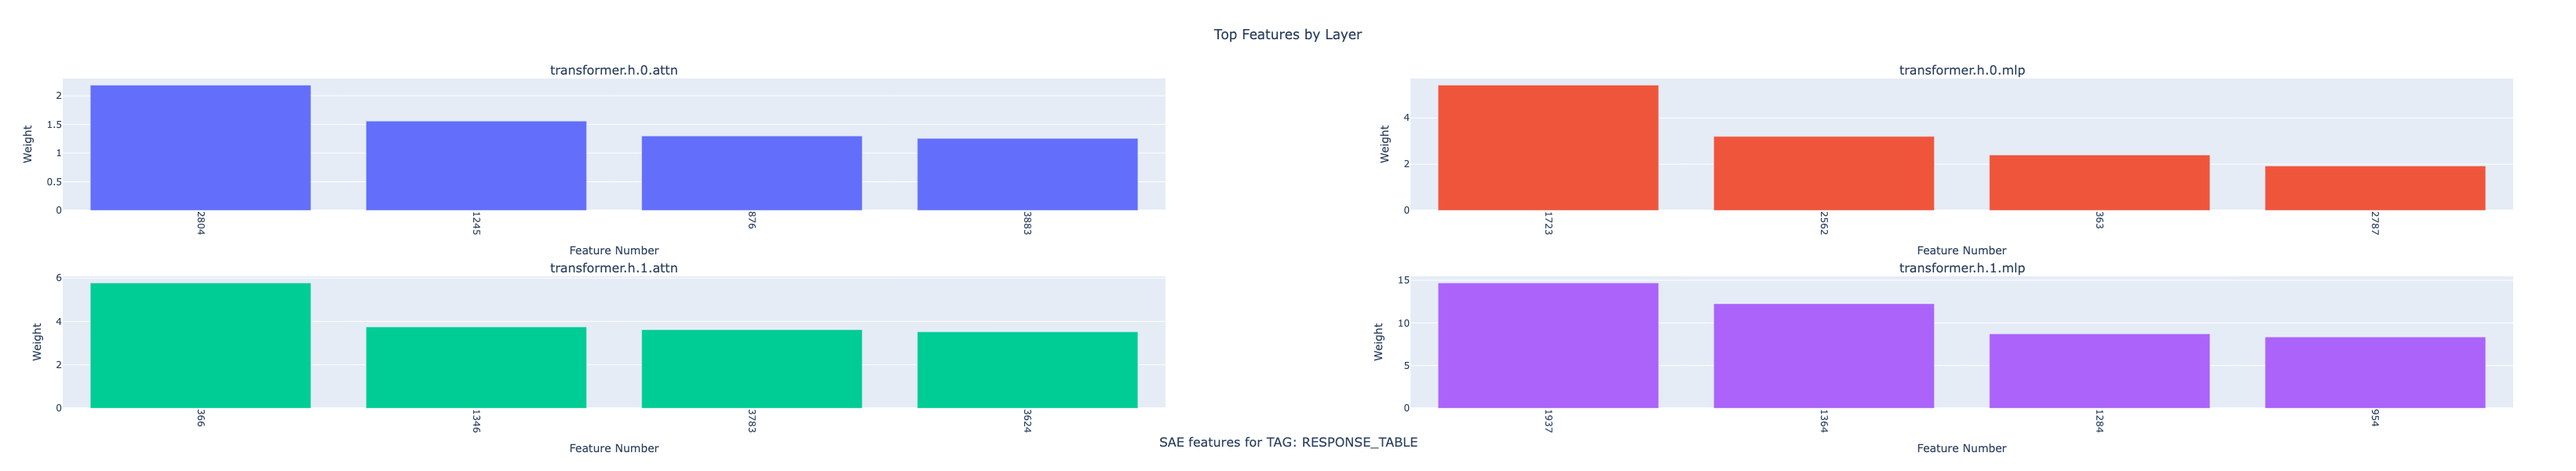

In [72]:
plot_layer_features(sorted_weights, tag, top_n=4)

**Get the maximum weight of a feature in an element.**

In [69]:
element = sae_collector.encoded_set[2]["encoding"]

In [73]:
target_feature = 2804
target_layer = "transformer.h.0.attn"

In [74]:
single_element = element.sae_outputs_by_layer[target_layer]

In [75]:
element.get_max_weight_of_feature(target_layer, target_feature)

3.61352276802063

In [76]:
# element.averaged_representation()

In [77]:
from circuitsvis.tokens import colored_tokens

In [78]:
texts, visualizations = sae_collector.get_maximally_activating_datasets(target_layer, target_feature)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 205.56it/s]


In [79]:
print(texts[2][0]["encoding"].tags_by_index)
texts[2][0]["encoding"].text

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [('FIELD', 'content')], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [('FIELD', 'salary')], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [('FIELD', 'altitude')], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [('TABLE', 'search'), ('CONTEXT_TABLE', 'search')], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [('FIELD', 'score')], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [('FIELD', 'altitude')], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [], 100: [], 101: [], 102: [], 103: [], 104: [], 105: [], 106: [],

'### Instruction: Look up rating, content_blob, survey_id, verified_at, salary, end_date, altitude and pending items from lookup tips ### Context: CREATE TABLE search_suggestions ( salary FLOAT, score DECIMAL(5,2), verified_at TIMESTAMP, altitude DECIMAL(9,6), content_blob BYTEA, survey_id INTEGER, end_date DATETIME, unread_count INTEGER ) ### Response: SELECT score, content_blob, survey_id, verified_at, salary, end_date, altitude, unread_count FROM search_suggestions'

In [80]:
for visualization in visualizations:
    display(visualization)

### Monitor reconstruction Errors.

In [66]:
reconstruction_error_by_k_and_layer = sae_collector.get_avg_reconstruction_error_for_all_k_and_layers()

  5%|████▋                                                                                        | 10/200 [00:05<01:49,  1.73it/s]


KeyboardInterrupt: 

In [ ]:
# reconstruction_error_by_k_and_layer

In [ ]:
plot_layer_curves(reconstruction_error_by_k_and_layer)

### Setup probe.

In [ ]:
# element.averaged_representation()

### Monitor Ablation Errors.